# ACE estimations from generated observational data
*This notebook examines the use of the `CausalEffectEstimation` module for estimating Average Causal Effects (ACE) in Observational Studies from generated data:* [Lunceford & Davidian (2004)]("https://pubmed.ncbi.nlm.nih.gov/15351954/")

In [1]:
import pyAgrum as gum
import pyAgrum.lib.notebook as gnb
import pyAgrum.lib.discretizer as disc
import pyAgrum.lib.explain as gexpl

import pyAgrum.causal as csl
import pyAgrum.causal.notebook as cslnb

import numpy as np
import pandas as pd

### Generated Data

* The *outcome* variable $Y$ is generated according the following equation:
$$ \begin{align*} 
Y & = - X_1 + X_2 - X_3 +2 T -V_1 + V_2 + V_3 \\
  & = \langle \nu , \boldsymbol{Z} \rangle + \langle \xi, \boldsymbol{V} \rangle
\end{align*}$$

Where $\nu = (0, -1, 1, -1, 2)^\intercal$, $\boldsymbol{Z} = (1, X_1, X_2, X_3, T)^\intercal$, $\xi = (-1,1,1)^\intercal$ and $\boldsymbol{V} = (V_1, V_2, V_3)^\intercal$. 

* The *covariates* are distributed as $X_3 \sim \text{Bernoulli}\left(0.2\right)$. Conditionally $X_3$, the distribution of the other variables is defined as:

If $X_{3} = 0$, $V_3 \sim \text{Bernoulli}\left(0.25\right)$ and
 ${\left(X_{1}, V_{1}, X_{2}, V_{2}\right)}^{\intercal} \sim \mathcal{N}_4({\tau}_{0}, \Sigma)$ 

If $ X_{3} = 1$, $V_3 \sim  \text{Bernoulli}\left(0.75\right)$ and ${\left(X_{1}, V_{1}, X_{2}, V_{2}\right)}^{\intercal} \sim \mathcal{N}_4({\tau}_{1}, \Sigma)$ 
with 
$$ {\tau}_{1} = \left(\begin{array}{c}
1 \\
1 \\
-1\\
-1 
\end{array}\right), {\tau}_{0} = \left(\begin{array}{c}
-1 \\
-1 \\
1\\
1 
\end{array}\right) \ \text{and} \ \Sigma = \left(\begin{array}{cccc}
1 & 0.5 & -0.5 & -0.5\\
0.5 & 1 & -0.5 & -0.5  \\
-0.5 & -0.5 & 1 & 0.5 \\
-0.5 & -0.5 & 0.5 & 1 
\end{array}
\right)$$

* The *treatment* $T$ is generated as a Bernoulli of the *propensity score*:
$$ \begin{align*}
\mathbb{P}[T=1|X] &= e\left(X, \beta\right) \\
&= (1+\exp (-0.6 X_{1} +0.6 X_{2} - 0.6 X_{3}))^{-1} \\
&= \frac{1}{1+e^{-\langle \beta , \boldsymbol{X} \rangle}} \\
\mathbb{P}[T=0|X] &= 1-\mathbb{P}[T=1|X]
\end{align*}$$
With $\beta = {\left(0, 0.6, -0.6, 0.6\right)}^{\intercal}$ and $\boldsymbol{X} = (1, X_1, X_2, X_3)^{\intercal}$.

In [2]:
# Model parameters
XI = np.array([-1, 1, 1])
NU = np.array([0, -1, 1, -1, 2])
BETA = np.array([0, 0.6, -0.6, 0.6])
TAU_0 = np.array([-1, -1, 1, 1])
TAU_1 = TAU_0 * -1
SIGMA = np.array([[1, 0.5, -0.5, -0.5],
                  [0.5, 1, -0.5, -0.5],
                  [-0.5, -0.5, 1, 0.5],
                  [-0.5, -0.5, 0.5, 1]], dtype=float)

def generate_lunceford(n=100000):
    # Generate data
    x3 = np.random.binomial(1, 0.2, n)
    v3 = np.random.binomial(1, (0.75 * x3 + (0.25 * (1 - x3))), n)

    # If x3=0 you have a model, if x3=1 you have another one
    x1v1x2v2_x3_0_matrix = np.random.multivariate_normal(TAU_0, SIGMA, size=n, check_valid='warn', tol=1e-8)
    x1v1x2v2_x3_1_matrix = np.random.multivariate_normal(TAU_1, SIGMA, size=n, check_valid='warn', tol=1e-8)
    x1v1x2v2_x3 = np.where(np.repeat(x3[:, np.newaxis], 4, axis=1) == 0, x1v1x2v2_x3_0_matrix, x1v1x2v2_x3_1_matrix)

    # Concatenate values
    xv = np.concatenate([x1v1x2v2_x3, np.expand_dims(x3, axis=1), np.expand_dims(v3, axis=1)], axis=1)

    # Compute e, a, and y
    x = xv[:, [0,2,4]]
    v = xv[:, [1,3,5]]
    e = np.power(1 + np.exp(- BETA[0] - x.dot(BETA[1:])), -1)
    a = np.random.binomial(1, e, n)
    y = x.dot(NU[1:-1]) + v.dot(XI) + a*NU[-1] + np.random.binomial(1, e, n) + np.random.normal(0, 1, n)

    # Create the final df
    synthetic_data_df = pd.DataFrame(np.concatenate([x, np.expand_dims(a, axis=1), v, np.expand_dims(y, axis=1)], axis=1), columns=["X1", "X2", "X3", "T", "V1", "V2", "V3", "Y"])
    synthetic_data_df["X3"] = synthetic_data_df["X3"].astype(int)
    synthetic_data_df["V3"] = synthetic_data_df["V3"].astype(int)
    synthetic_data_df["T"] = synthetic_data_df["T"].astype(int)

    return synthetic_data_df

df = generate_lunceford()

df.head()

,X1,X2,X3,T,V1,V2,V3,Y
0,-0.796852,1.124379,0,0,0.370816,1.450550,0,3.786748
1,-2.232394,3.140406,0,0,-2.724380,1.615860,0,9.863480
2,-1.580584,2.501709,0,0,-0.486103,1.021496,0,6.688336
3,-0.182456,-1.615993,1,1,-0.359916,-0.259416,1,-0.580552
4,-0.714911,0.297377,0,0,-0.420731,1.113113,1,5.313941


Here, the exact ATE can be explicitly calculated using the previously defined assumptions.

$$ \begin{align*}
\mathbb{E}[Y(1) - Y(0)] &= \mathbb{E}_{X,V}[\mathbb{E}[Y \mid T=1, X, V] - \mathbb{E}[Y \mid T=0, X, V]]\\
&= \mathbb{E} [ (- X_1 + X_2 - X_3 + 2 \times 1 -V_1 + V_2 + V_3)] - \mathbb{E}[(- X_1 + X_2 - X_3 + 2 \times 0 -V_1 + V_2 + V_3 ) ] \\
&= 2
\end{align*} $$

### Setup

Given that we know the data-generating mechanism, we can directly specify the causal structure by constructing a Causal Bayesian Network. To utilize the CausalBNEstimator, we will first employ the discretizer module to determine the domains of the variables.

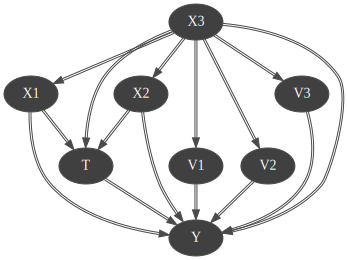

In [3]:
discretizer = disc.Discretizer(
    defaultDiscretizationMethod='uniform',
    defaultNumberOfBins=10
)
discretizer.setDiscretizationParameters("Y", 'uniform', 60)

bn = discretizer.discretizedTemplate(df)

bn.beginTopologyTransformation()
for _, name in bn:
    if name != "Y":
        bn.addArc(name, "Y")
for X in ["X1", "X2", "X3"]:
    bn.addArc(X, "T")
for XV in ["X1", "V1", "X2", "V2"]:
    bn.addArc("X3", XV)
bn.addArc("X3", "V3")
bn.endTopologyTransformation()

causal_model = csl.CausalModel(bn)

cslnb.showCausalModel(causal_model, size="10")

In [4]:
cee = csl.CausalEffectEstimation(df, causal_model)

### Causal Identification

In [5]:
cee.identifyAdjustmentSet(intervention="T", outcome="Y")

Backdoor adjustment found. 

Supported estimators include:
- CausalModelEstimator
- SLearner
- TLearner
- XLearner
- PStratification
- IPW


'Backdoor'

### Causal Estimation

In [6]:
cee.fitCausalBNEstimator()
tau_hat = cee.estimateCausalEffect()

print(f"ACE linear = {tau_hat}, MAPE = {abs((tau_hat-2)/2*100)} %")

ACE linear = 1.3817905023592614, MAPE = 30.91047488203693 %


In [7]:
cee.fitSLearner()
tau_hat = cee.estimateCausalEffect()

print(f"ACE linear = {tau_hat}, MAPE = {abs((tau_hat-2)/2)*100} %")

ACE linear = 2.0306941404817436, MAPE = 1.5347070240871785 %


In [8]:
cee.fitTLearner()
tau_hat = cee.estimateCausalEffect()

print(f"ACE linear = {tau_hat}, MAPE = {abs((tau_hat-2)/2)*100} %")

ACE linear = 2.025380315280804, MAPE = 1.2690157640401933 %


In [9]:
cee.fitIPW()
tau_hat = cee.estimateCausalEffect()

print(f"ACE linear = {tau_hat}, MAPE = {abs((tau_hat-2)/2)*100} %")

ACE linear = 2.0705174703671703, MAPE = 3.5258735183585133 %


### Structure Learning with imposed slice order

We will assess the performance of the `BNLearner` module to uncover the causal structure of the dataset. A slice order will be imposed on the variables to guide the learning process. Following the identification of the structure via the Structure Learning algorithm, we will proceed to estimate the causal effect based on the inferred structure.

In [10]:
template = discretizer.discretizedTemplate(df)

structure_learner = gum.BNLearner(df, template)
structure_learner.useNMLCorrection()
structure_learner.useSmoothingPrior(1e-9)
structure_learner.setSliceOrder([["X3","X1","X2","V1","V2","V3"], ["T"], ["Y"]])

learned_bn = structure_learner.learnBN()
learned_causal_model = csl.CausalModel(learned_bn)

print(structure_learner)

Filename               : /tmp/tmpmeyg214n.csv
Size                   : (100000,8)
Variables              : X1[10], X2[10], X3[2], T[2], V1[10], V2[10], V3[2], Y[60]
Induced types          : False
Missing values         : False
Algorithm              : MIIC
Score                  : BDeu  (Not used for constraint-based algorithms)
Correction             : NML  (Not used for score-based algorithms)
Prior                  : Smoothing
Prior weight           : 0.000000
Constraint Slice Order : {T:1, X2:0, V3:0, V1:0, Y:2, X3:0, X1:0, V2:0}



In [11]:
gnb.sideBySide(gexpl.getInformation(learned_bn, size="50"),
               gnb.getInference(learned_bn, size="50"))

Subsequently, we will reuse the previously established pipeline to estimate the causal effect based on the identified structure.

In [12]:
cee = csl.CausalEffectEstimation(df, learned_causal_model)

In [13]:
cee.identifyAdjustmentSet(intervention="T", outcome="Y")

Backdoor adjustment found. 

Supported estimators include:
- CausalModelEstimator
- SLearner
- TLearner
- XLearner
- PStratification
- IPW


'Backdoor'

In [14]:
cee.fitCausalBNEstimator()
tau_hat = cee.estimateCausalEffect()

print(f"ACE linear = {tau_hat}, MAPE = {abs((tau_hat-2)/2*100)} %")

ACE linear = 1.3400851591586689, MAPE = 32.99574204206655 %


In [15]:
cee.fitSLearner()
tau_hat = cee.estimateCausalEffect()

print(f"ACE linear = {tau_hat}, MAPE = {abs((tau_hat-2)/2)*100} %")

ACE linear = 2.0306941404817436, MAPE = 1.5347070240871785 %


In [16]:
cee.fitTLearner()
tau_hat = cee.estimateCausalEffect()

print(f"ACE linear = {tau_hat}, MAPE = {abs((tau_hat-2)/2)*100} %")

ACE linear = 2.025380315280804, MAPE = 1.2690157640401933 %


In [17]:
cee.fitIPW()
tau_hat = cee.estimateCausalEffect()

print(f"ACE linear = {tau_hat}, MAPE = {abs((tau_hat-2)/2)*100} %")

ACE linear = 2.0705174703671703, MAPE = 3.5258735183585133 %


We observe that the results remain largely consistent when imposing a slice order on the variables. However, the `CausalBNEstimator` appears to be the most sensitive to structural changes, as it relies on the entire graph structure for its estimations.

### Structure Learning with imposed slice order

Next, we will evaluate the estimations produced when allowing the algorithm to perform structure learning autonomously, without imposing any slice order.

In [18]:
template = discretizer.discretizedTemplate(df)

structure_learner = gum.BNLearner(df, template)
structure_learner.useNMLCorrection()
structure_learner.useSmoothingPrior(1e-9)

learned_bn = structure_learner.learnBN()
learned_causal_model = csl.CausalModel(learned_bn)

print(structure_learner)

Filename       : /tmp/tmp1rl7yjae.csv
Size           : (100000,8)
Variables      : X1[10], X2[10], X3[2], T[2], V1[10], V2[10], V3[2], Y[60]
Induced types  : False
Missing values : False
Algorithm      : MIIC
Score          : BDeu  (Not used for constraint-based algorithms)
Correction     : NML  (Not used for score-based algorithms)
Prior          : Smoothing
Prior weight   : 0.000000



In [19]:
gnb.sideBySide(gexpl.getInformation(learned_bn, size="50"),
               gnb.getInference(learned_bn, size="50"))

We are encountering challenges at the outset, as numerous causal relationships are misspecified, with multiple covariates incorrectly identified as causes of the outcome. Despite this, the intervention variable is correctly identified as a cause of the outcome. With limited expectations, let us now examine the estimation results.

In [20]:
cee = csl.CausalEffectEstimation(df, learned_causal_model)

In [21]:
cee.identifyAdjustmentSet(intervention="T", outcome="Y")

Randomized Controlled Trial adjustment found. 

Supported estimators include:
- CausalModelEstimator
- DM
If the outcome variable is a cause of other covariates in the causal graph,
Backdoor estimators may also be used.


'Randomized Controlled Trial'

In [22]:
cee.fitCausalBNEstimator()
tau_hat = cee.estimateCausalEffect()

print(f"ACE linear = {tau_hat}, MAPE = {abs((tau_hat-2)/2*100)} %")

ACE linear = 0.8986892811515819, MAPE = 55.06553594242091 %


In [23]:
cee.fitDM()
tau_hat = cee.estimateCausalEffect()

print(f"ACE linear = {tau_hat}, MAPE = {abs((tau_hat-2)/2)*100} %")

ACE linear = -2.8736800188410396, MAPE = 243.68400094205197 %


The results are exceptionally poor. In an attempt to address this issue, we will investigate whether controlling for covariates that are identified as causes of the outcome in the causal graph improves the estimation.

In [24]:
cee.useBackdoorAdjustment(intervention="T", outcome="Y", confounders={"V1", "V2"})

In [25]:
cee.fitSLearner()
tau_hat = cee.estimateCausalEffect()

print(f"ACE linear = {tau_hat}, MAPE = {abs((tau_hat-2)/2)*100} %")

ACE linear = 1.0147647714410832, MAPE = 49.261761427945835 %


In [26]:
cee.fitTLearner()
tau_hat = cee.estimateCausalEffect()

print(f"ACE linear = {tau_hat}, MAPE = {abs((tau_hat-2)/2)*100} %")

ACE linear = 1.0488371908758642, MAPE = 47.558140456206786 %


One might assume that the estimation methods are not sufficiently sophisticated, given that the default meta-learners utilize Linear Regression as the base model. To address this, we will assess whether employing `XGBRegressor` as the base learner within the `XLearner` framework improves the estimation results.

In [27]:
cee.fitXLearner(learner="XGBRegressor")
tau_hat = cee.estimateCausalEffect()

print(f"ACE linear = {tau_hat}, MAPE = {abs((tau_hat-2)/2)*100} %")

ACE linear = 1.063324997531158, MAPE = 46.833750123442094 %


The results show only marginal improvement, insufficient to draw reliable conclusions about the true causal effect.

This underscores the critical role of domain knowledge in accurately specifying the underlying causal structure. Even the most sophisticated estimation methods can falter when the causal structure is incorrectly specified.

### Remarks

Overall, we observe that Bayesian Network-based estimators consistently underestimate the ACE. This underestimation arises due to the discretization and learning processes, which tend to homogenize the data by averaging it out. Since the ACE is computed as the difference between two expectations, this induced homogeneity reduces the variance between the groups, leading to a smaller difference and consequently an underestimation of the ACE.